In [2]:
!pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
%matplotlib inline
import pymc as pm
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import logsumexp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import arviz as az
import networkx as nx
import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

plt.style.use(['seaborn-v0_8-darkgrid','seaborn-v0_8-colorblind'])

#### Code 8.1

In [4]:
d = pd.read_csv('data/rugged.csv', sep=';')

# make log version of outcome
d['log_gdp'] = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[~d['rgdppc_2000'].isna()]

# rescale variables
dd['log_gdp_std'] = d['log_gdp'] / d['log_gdp'].mean()
dd['rugged_std'] = dd['rugged'] / dd['rugged'].max()



#### Code 8.2

In [6]:
with pm.Model() as m8_1: 
    sigma = pm.Exponential('sigma', 1) 
    a = pm.Normal('a', 1,1,)
    b = pm.Normal('b',0,1)
    mu = pm.Deterministic('mu', a + b * (dd['rugged_std'] - 0.215)) # 
    log_gdp_std = pm.Normal('log_gdp_std', mu = mu,
                                           sigma = sigma,
                                           observed = dd['log_gdp_std'])
    trace_m8_1 = pm.sample(cores = 1, 
                          chains = 4, 
                          idata_kwargs={'log_likelihood': True}, 
                           progressbar=False)
    

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [a, b, log_gdp_std, sigma]


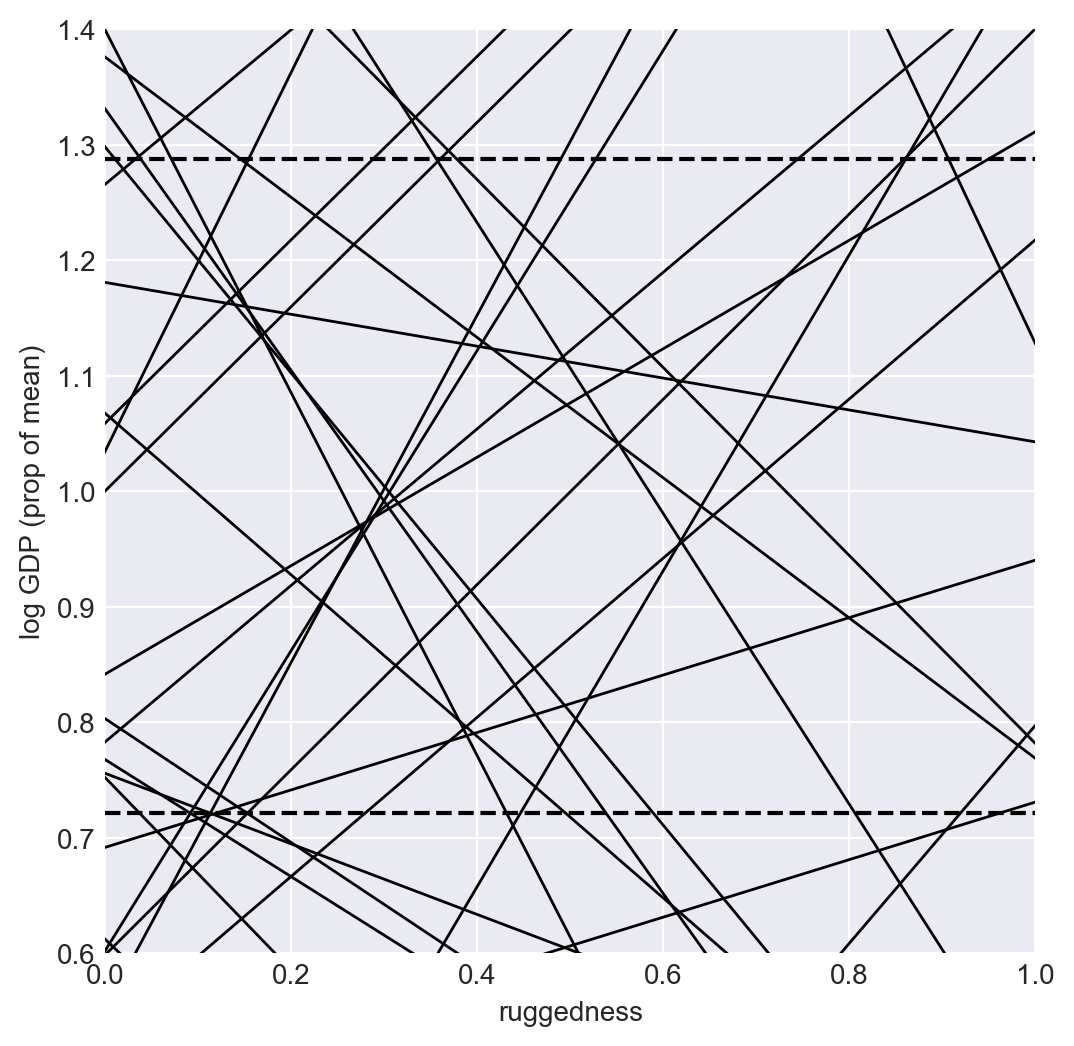

In [7]:
with m8_1:
    prior = pm.sample_prior_predictive(samples = 1000
                                    ).prior.to_dataframe(
                                    ).reset_index(
                                    ).drop_duplicates(subset=['chain','draw']
                                    ).reset_index(
                                    )[['a','b','sigma']]


# set up the plot dimensions
plt.figure(figsize=(6,6));
plt.xlim(0,1)
plt.ylim(.6,1.4);
plt.hlines(min(dd.log_gdp_std), 0, 1, linestyles='dashed', color='black')
plt.hlines(max(dd.log_gdp_std), 0, 1, linestyles='dashed', color='black')
plt.xlabel('ruggedness')
plt.ylabel('log GDP (prop of mean)')

#draw 50 lines from the prior
rugged_seq = np.linspace(-.1, 1.1, 30)
for _, row in prior.sample(50, random_state=42).iterrows():
    mu = row['a'] + row['b'] * rugged_seq
    plt.plot(rugged_seq, mu, color='black', lw=1)

#### Code 8.4

In [8]:
np.sum(np.abs(prior.b) > .6) / len(prior.b)

0.54

#### Code 8.4

In [22]:
with pm.Model() as m8_1: 
    sigma = pm.Exponential('sigma', 1) 
    a = pm.Normal('a', 1, .1)
    b = pm.Normal('b',0, .3)
    mu = pm.Deterministic('mu', a + b * (dd['rugged_std'] - 0.215)) # 
    log_gdp_std = pm.Normal('log_gdp_std', mu = mu,
                                           sigma = sigma,
                                           observed = dd['log_gdp_std'])
    trace_m8_1 = pm.sample(cores = 1, 
                           chains = 4, 
                           idata_kwargs={'log_likelihood': True}, 
                           progressbar=False)
    

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


#### Code 8.6

In [23]:
pm.summary(trace_m8_1, var_names=['a', 'b', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.000,0.011,0.980,1.020,0.000,0.000,6135.0,2871.0,1.0
b,0.003,0.055,-0.097,0.109,0.001,0.001,5694.0,2856.0,1.0
sigma,0.138,0.007,0.124,0.152,0.000,0.000,5234.0,3165.0,1.0


#### Code 8.7

In [ ]:
dd['cid'] = np.where(dd.cont_africa == 1, 1, 0) 
#pymc is 0 indexed so this is somewhat meaningless but we'll do it for sake of consistency

#### Code 8.8

In [ ]:

with pm.Model() as m8_2: 
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 1, .1, shape = 2)
    b = pm.Normal('b', 0, .3)
    mu = pm.Deterministic('mu', a[dd.cid] + b * (dd['rugged_std'] - 0.215)) 
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sigma=sigma, observed=dd['log_gdp_std'])
    trace_m8_2 = pm.sample(cores=1, chains=4, idata_kwargs={'log_likelihood': True}, progressbar=False)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


#### Code 8.9

In [65]:
pm.compare({'m8.1': trace_m8_1, 'm8.2': trace_m8_2}, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m8.2,0,126.130510,4.155506,0.000000,0.970281,7.391820,0.000000,True,log
m8.1,1,94.451118,2.565890,31.679392,0.029719,6.470628,7.307007,False,log


#### Code 8.10

In [66]:
pm.summary(trace_m8_2, var_names=['a', 'b', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.049,0.010,1.030,1.069,0.000,0.000,6832.0,3109.0,1.0
a[1],0.881,0.016,0.852,0.912,0.000,0.000,5819.0,3487.0,1.0
b,-0.044,0.047,-0.132,0.042,0.001,0.001,6239.0,2901.0,1.0
sigma,0.114,0.006,0.103,0.126,0.000,0.000,5811.0,3364.0,1.0


#### Code 8.11

In [81]:
post = trace_m8_2.posterior.to_dataframe().reset_index()
diff_a1_a2 = np.array(post.a[post.a_dim_0 == 1]) - np.array(post.a[post.a_dim_0 == 0])
az.hdi(diff_a1_a2, hdi_prob=.89)

array([-0.19964032, -0.13891858])

#### Code 8.12

In [107]:
rugged_seq = np.linspace(-.1, 1.1, 30) 

# compute mu over samples, fixing cid = 0
mu_NotAfrica = post.a[post.a_dim_0 == 0].values[:, None] + post.b[post.a_dim_0 == 0].values[:,None] * (rugged_seq[None, :])

# compute mu over samples, fixing cid = 1
mu_Africa = post.a[post.a_dim_0 == 1].values[:, None] + post.b[post.a_dim_0 == 1].values[:,None] * (rugged_seq[None, :])

mu_NotAfrica_mean = mu_NotAfrica.mean(0)
mu_NotAfrica_ci = az.hdi(mu_NotAfrica, hdi_prob=.97)

mu_Africa_mean = mu_Africa.mean(0)
mu_Africa_ci = az.hdi(mu_Africa, hdi_prob=.97)


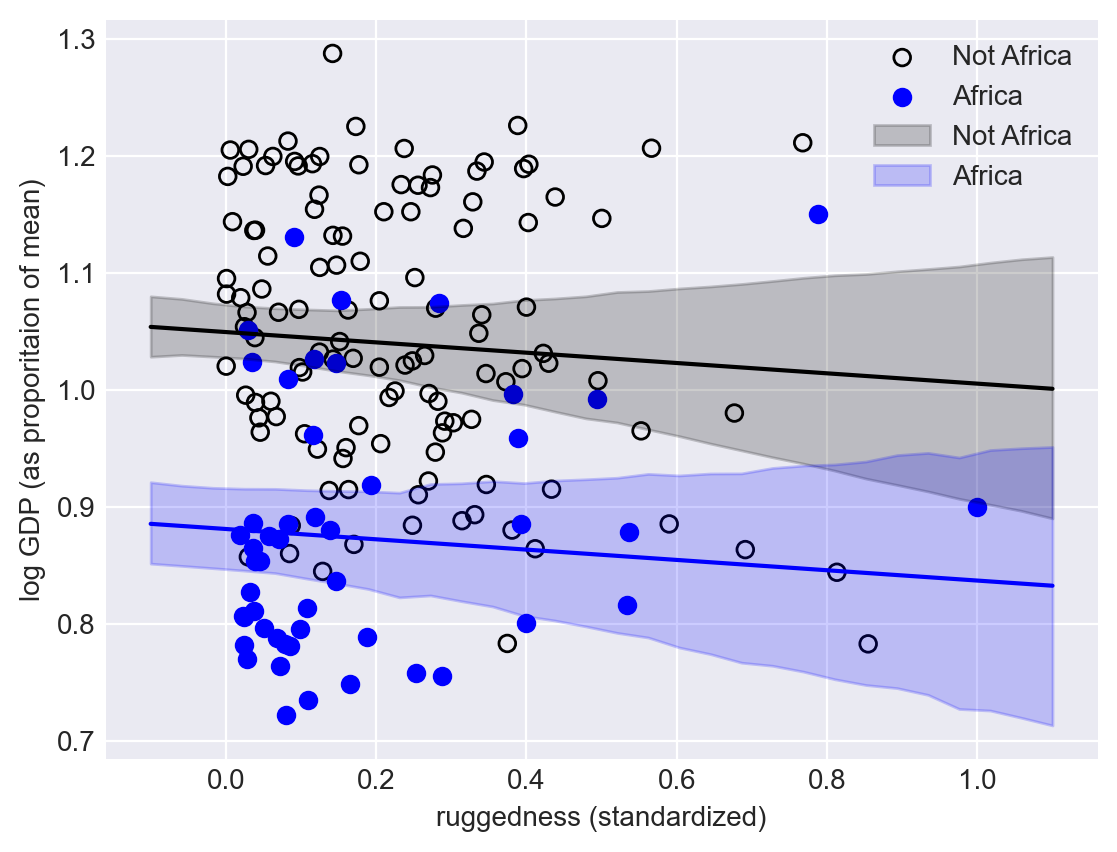

In [116]:
plt.scatter(dd.rugged_std[dd.cid == 0], dd.log_gdp_std[dd.cid == 0], facecolor = 'none', edgecolor ='black', label = 'Not Africa')
plt.scatter(dd.rugged_std[dd.cid == 1], dd.log_gdp_std[dd.cid == 1], color ='blue', label = 'Africa')
plt.plot(rugged_seq, mu_NotAfrica_mean,color = 'black')
plt.fill_between(rugged_seq, mu_NotAfrica_ci[:,0], mu_NotAfrica_ci[:,1], color= 'black', alpha = .2, label = 'Not Africa')
plt.plot(rugged_seq, mu_Africa_mean,color = 'blue')
plt.fill_between(rugged_seq, mu_Africa_ci[:,0], mu_Africa_ci[:,1], color= 'blue', alpha = .2, label = 'Africa')
plt.legend()
plt.xlabel('ruggedness (standardized)')
plt.ylabel('log GDP (as proporitaion of mean)');

#### Code 8.13

In [117]:
with pm.Model() as m8_3:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 1.,1, shape = 2)
    b = pm.Normal('b', 0, .3, shape = 2)
    mu = pm.Deterministic('mu', a[dd.cid] + b[dd.cid] * (dd.rugged_std - .215))
    log_gpd_std = pm.Normal('log_gpd_std', mu = mu, sigma = sigma, observed = dd.log_gdp_std)
    trace_m8_3 = pm.sample(cores = 1, chains = 4, idata_kwargs={'log_likelihood': True}, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


#### Code 8.14

In [118]:
pm.summary(trace_m8_3, var_names=['a', 'b', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.051,0.010,1.032,1.070,0.000,0.000,7805.0,3522.0,1.0
a[1],0.884,0.016,0.854,0.915,0.000,0.000,7797.0,3345.0,1.0
b[0],-0.141,0.056,-0.244,-0.031,0.001,0.001,6677.0,2929.0,1.0
b[1],0.130,0.075,-0.009,0.271,0.001,0.001,5713.0,3647.0,1.0
sigma,0.112,0.006,0.101,0.124,0.000,0.000,6591.0,3359.0,1.0


#### Code 8.15

In [122]:
pm.compare({'m8.1': trace_m8_1, 'm8.2': trace_m8_2, 'm8.3': trace_m8_3})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m8.3,0,129.539679,5.068059,0.000000,0.870015,7.377034,0.000000,False,log
m8.2,1,126.107109,4.178907,3.432570,0.129985,7.398715,3.191121,False,log
m8.1,2,94.442171,2.574837,35.097508,0.000000,6.471353,7.603101,False,log


#### Code 8.16

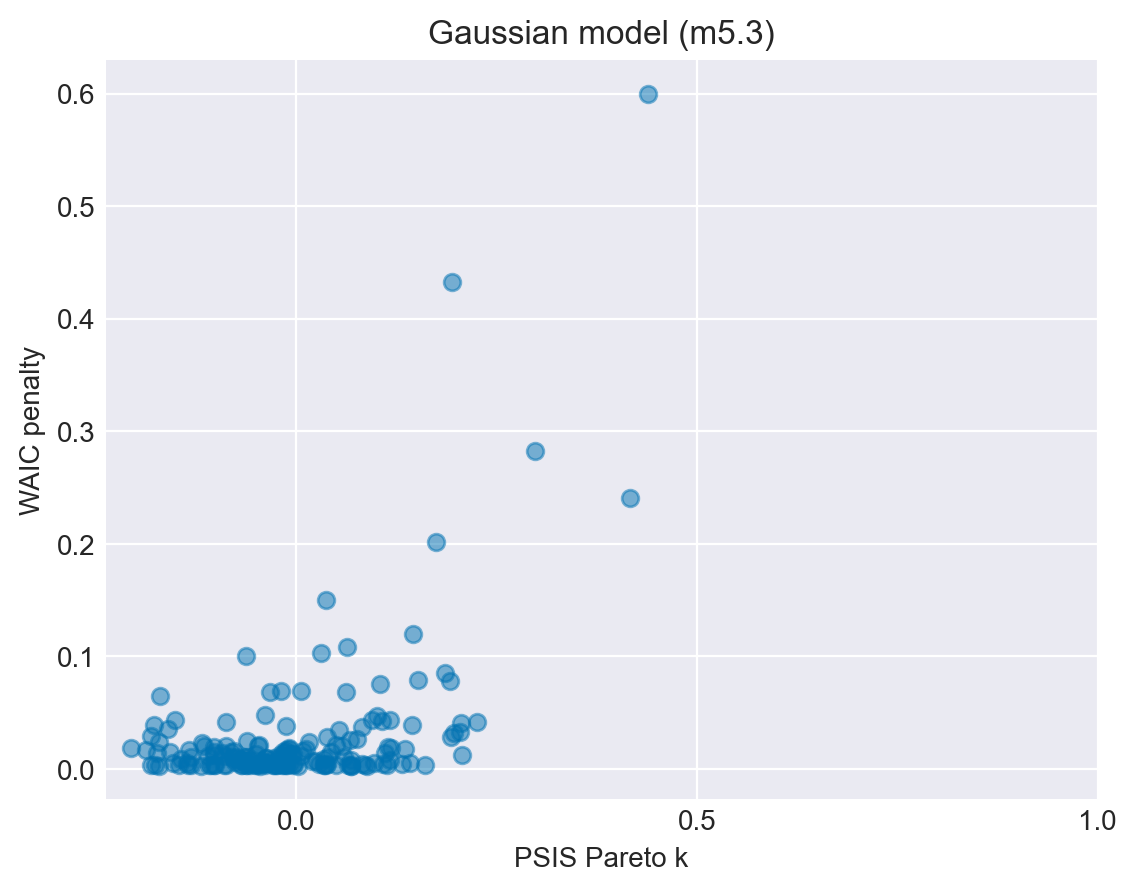

In [ ]:
loo_m8_3 = az.loo(trace_m8_3, pointwise=True)
pareto_k = loo_m8_3.pareto_k.values

log_prob = trace_m8_3.log_likelihood.log_gpd_std.values
ns = log_prob.shape[0] * log_prob.shape[1]  
n = log_prob.shape[2] 
logprob = log_prob.reshape(ns, n)
p_waic_pointwise = np.array([np.var(logprob[:, i]) for i in range(n)])

plt.scatter(pareto_k, p_waic_pointwise, alpha=0.5)
plt.xlabel('PSIS Pareto k')
plt.ylabel('WAIC penalty')
plt.title('Gaussian model (m5.3)')
plt.xticks([0.0, .5, 1])
plt.show()

#### Code 8.17

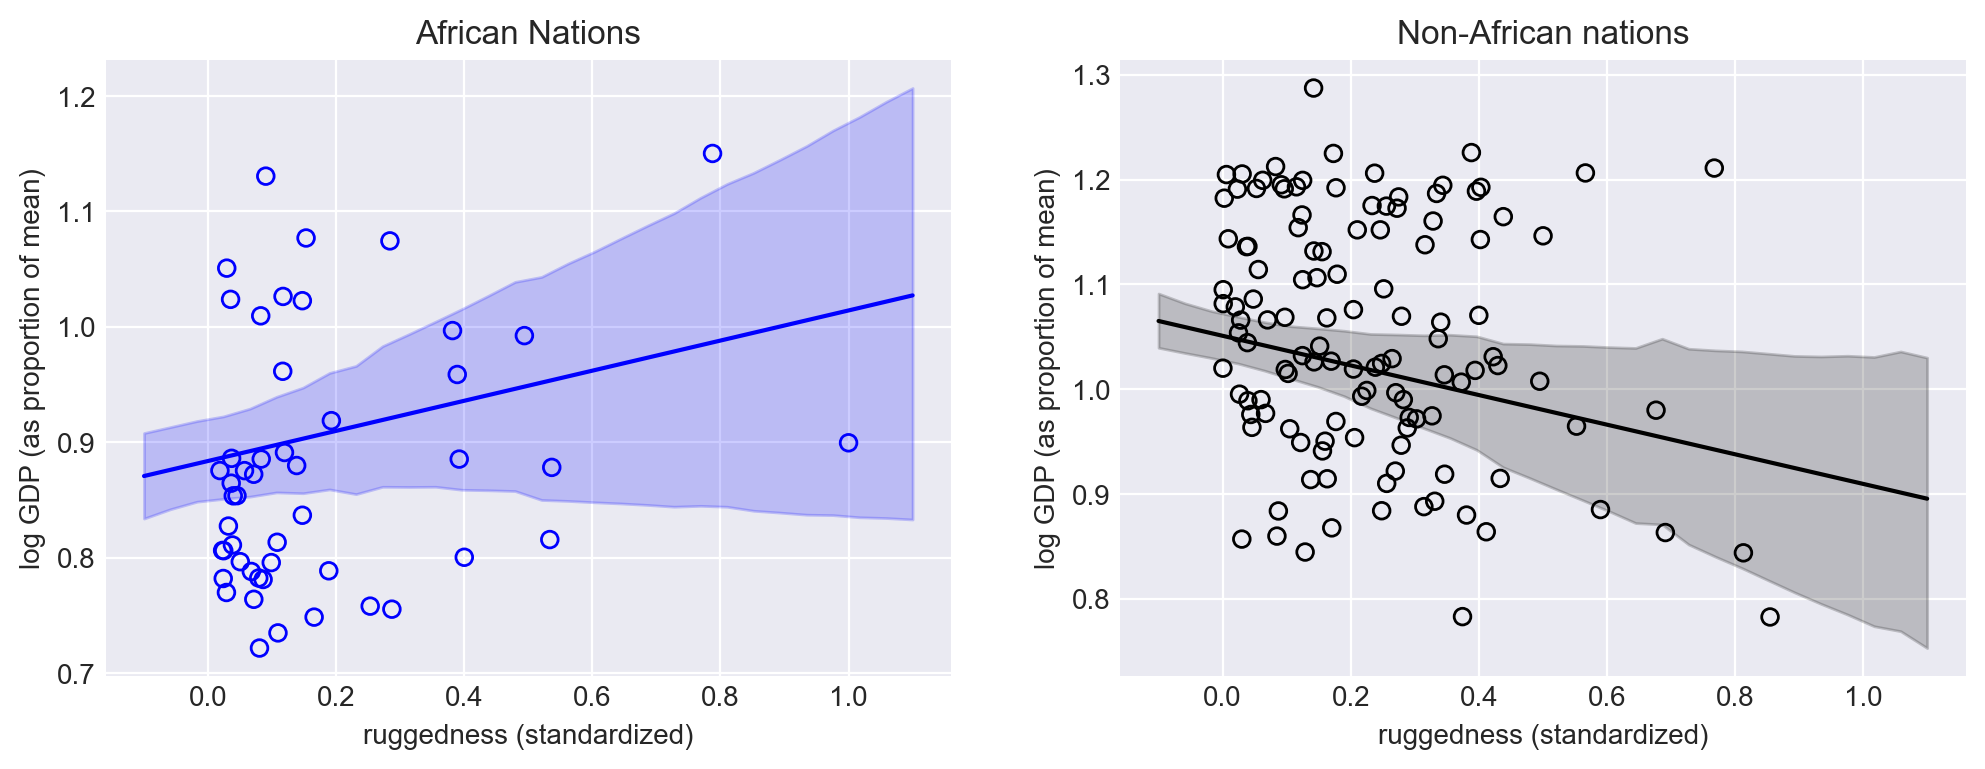

In [159]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
post_m8_3 = trace_m8_3.posterior.to_dataframe().reset_index()



d_A1 = dd[dd['cid'] == 1]
ax1.scatter(d_A1.rugged_std, d_A1.log_gdp_std, facecolor = 'none', edgecolor = 'blue')
rugged_seq = np.linspace(-.1, 1.1, 30) 
mu_Africa = post_m8_3.a[post_m8_3.a_dim_0 == 1].values[:, None] + post_m8_3.b[post_m8_3.b_dim_0 == 1].values[:,None] * (rugged_seq[None, :])
mu_Africa_mean = mu_Africa.mean(0)
mu_Africa_ci = az.hdi(mu_Africa, hdi_prob=.97)
ax1.plot(rugged_seq, mu_Africa_mean, color = 'blue')
ax1.fill_between(rugged_seq, mu_Africa_ci[:,0], mu_Africa_ci[:,1], color= 'blue', alpha = .2, label = 'Africa')
ax1.set_xlabel('ruggedness (standardized)')
ax1.set_ylabel('log GDP (as proportion of mean)')
ax1.set_title('African Nations')

d_A0 = dd[dd['cid'] == 0]
ax2.scatter(d_A0.rugged_std, d_A0.log_gdp_std, facecolor = 'none', edgecolor = 'black')
rugged_seq = np.linspace(-.1, 1.1, 30) 
mu_NonAfrica = post_m8_3.a[post_m8_3.a_dim_0 == 0].values[:, None] + post_m8_3.b[post_m8_3.b_dim_0 == 0].values[:,None] * (rugged_seq[None, :])
mu_NonAfrica_mean = mu_NonAfrica.mean(0)
mu_NonAfrica_ci = az.hdi(mu_NonAfrica, hdi_prob=.97)
ax2.plot(rugged_seq, mu_NonAfrica_mean, color = 'black')
ax2.fill_between(rugged_seq, mu_NonAfrica_ci[:,0], mu_NonAfrica_ci[:,1], color= 'black', alpha = .2, label = 'Non-Africa')
ax2.set_xlabel('ruggedness (standardized)')
ax2.set_ylabel('log GDP (as proportion of mean)')
ax2.set_title('Non-African nations');



#### Code 8.18

''

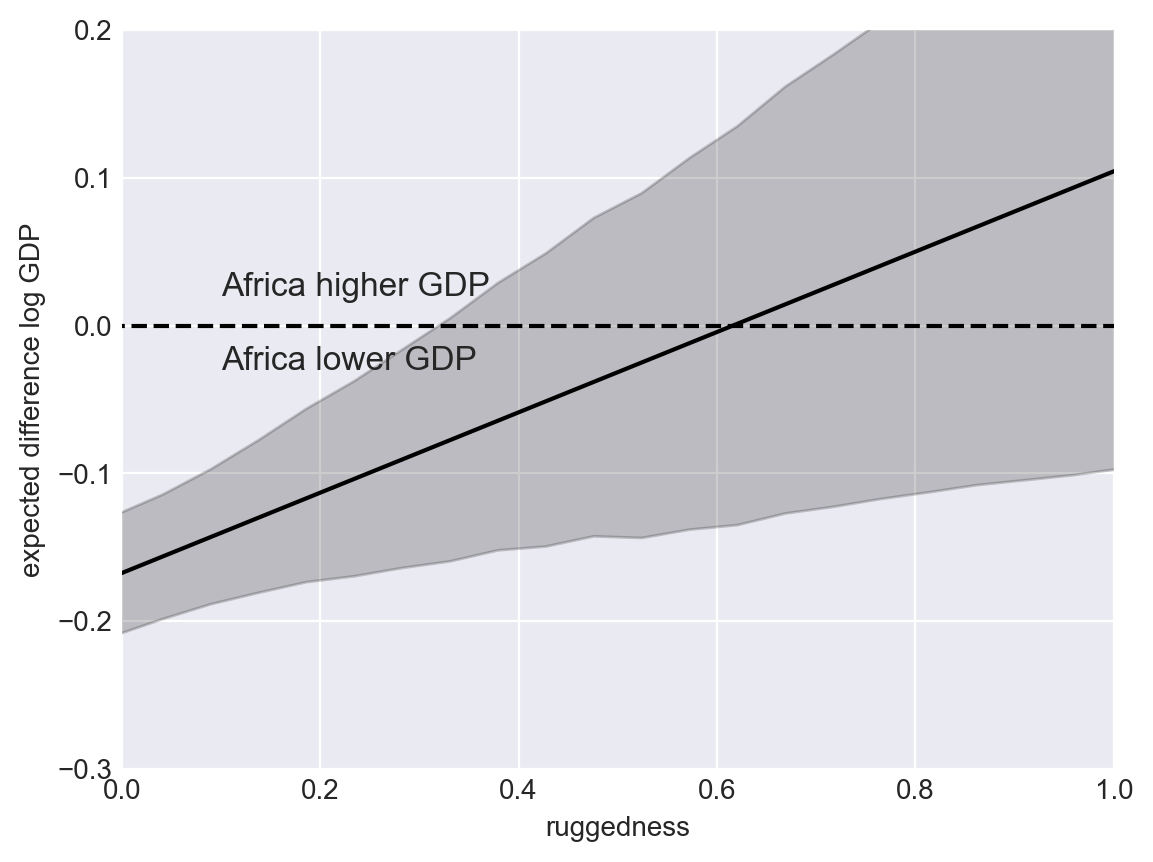

In [177]:
rugged_seq = np.linspace(-.2, 1.2, 30) 
muA = post_m8_3.a[post_m8_3.a_dim_0 == 1].values[:, None] + post_m8_3.b[post_m8_3.b_dim_0 == 1].values[:,None] * (rugged_seq[None, :])
muN = post_m8_3.a[post_m8_3.a_dim_0 == 0].values[:, None] + post_m8_3.b[post_m8_3.b_dim_0 == 0].values[:,None] * (rugged_seq[None, :])
delta = muA - muN
delta_mean = delta.mean(0)
delta_ci = az.hdi(delta, hdi_prob=.97)

plt.plot(rugged_seq, delta_mean, color = 'black')
plt.fill_between(rugged_seq, delta_ci[:,0], delta_ci[:,1], color = 'black', alpha = .2)
plt.hlines(0, rugged_seq[0], rugged_seq[-1], linestyles = 'dashed', color = 'black')
plt.xlabel('ruggedness')
plt.ylabel('expected difference log GDP')
plt.ylim(-.3,.2)
plt.xlim(0, 1)
plt.text(0.1, 0.02, 'Africa higher GDP',size = 12)
plt.text(0.1, -0.03, 'Africa lower GDP',size = 12)
;


#### Code 8.19

In [188]:
d = pd.read_csv('data/tulips.csv', sep=';')
d.describe().T

,count,mean,std,min,25%,50%,75%,max
water,27.0,2.000000,0.832050,1.0,1.000,2.00,3.0,3.00
shade,27.0,2.000000,0.832050,1.0,1.000,2.00,3.0,3.00
blooms,27.0,128.993704,92.683923,0.0,71.115,111.04,190.3,361.66


#### Code 8.20

In [190]:
d['blooms_std'] = d.blooms / d.blooms.max() 
d['water_cent'] = d.water - d.water.mean() 
d['shade_cent'] = d.shade - d.shade.mean() 

#### Code 8.21

In [192]:
a = np.random.normal(.5,1, 1000)
np.sum((a < 0 )| (a > 1)) / len(a)

0.618

#### Code 8.22

In [193]:
a = np.random.normal(.5,.25, 1000)
np.sum((a < 0 )| (a > 1)) / len(a)

0.05

#### Code 8.23

In [ ]:
with pm.Model() as m8_4:
    sigma = pm.Exponential('simga',1)
    a = pm.Normal('a',.5,.25)
    bw = pm.Normal('bw', 0, .25)
    bs= pm.Normal('bs', 0, .25)
    mu = pm.Deterministic('mu', a + bw*d.water_cent + bs*d.shade_cent)
    blooms_std = pm.Normal('blooms_std', mu = mu, sigma = sigma, observed = d.blooms_std)
    trace_m8_4 = pm.sample(cores = 1, chains = 4, idata_kwargs={'log_likelihood': True}, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [simga, a, bw, bs]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


#### Code 8.24

In [197]:
with pm.Model() as m8_5:
    sigma = pm.Exponential('simga',1)
    a = pm.Normal('a',.5,.25)
    bw = pm.Normal('bw', 0, .25)
    bs= pm.Normal('bs', 0, .25)
    bws = pm.Normal('bws', 0, .25)
    mu = pm.Deterministic('mu', a + bw*d.water_cent + bs*d.shade_cent + bws*d.water_cent*d.shade_cent)
    blooms_std = pm.Normal('blooms_std', mu = mu, sigma = sigma, observed = d.blooms_std)
    trace_m8_5 = pm.sample(cores = 1, chains = 4, idata_kwargs={'log_likelihood': True}, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [simga, a, bw, bs, bws]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


#### Code 8.25

(0.0, 1.0)

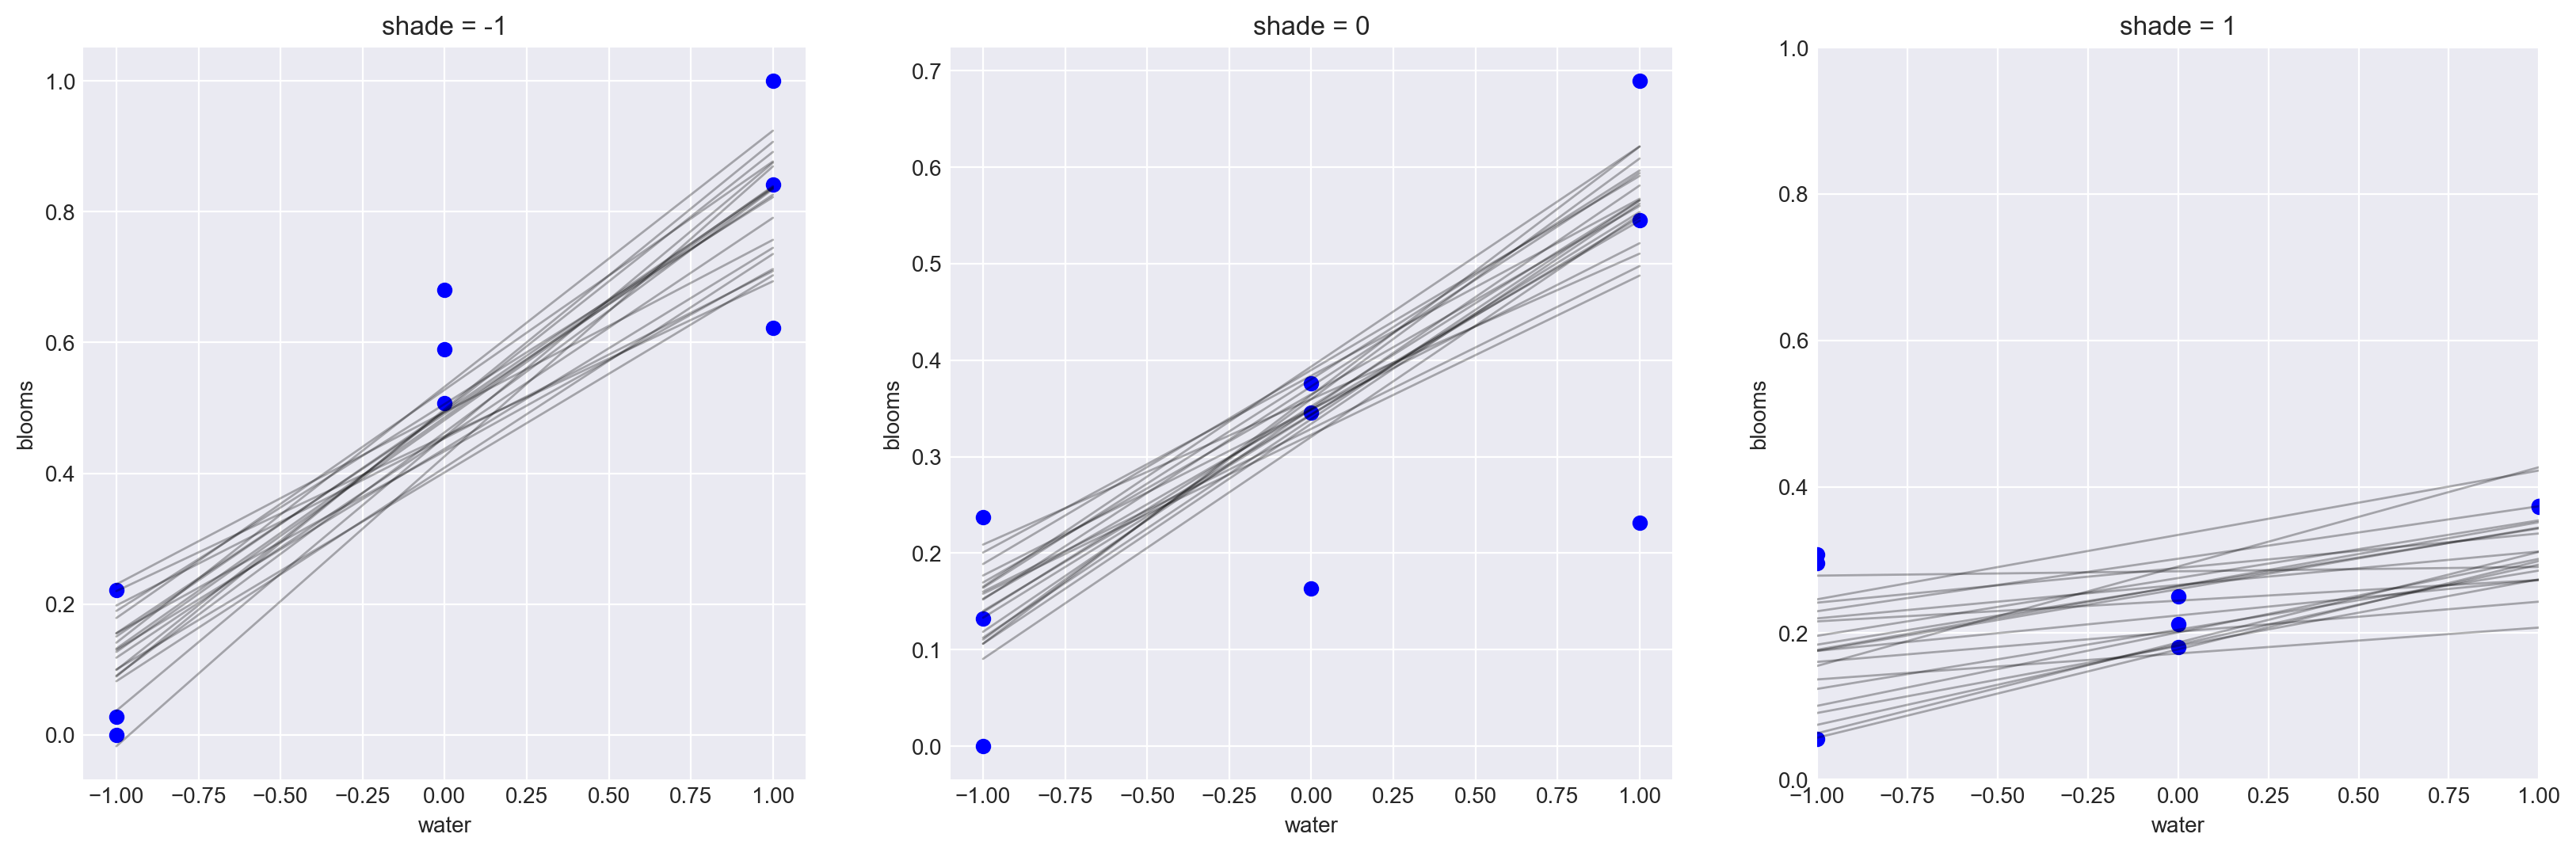

In [224]:
post = trace_m8_5.posterior.to_dataframe().reset_index()
post_samples = post[['a', 'bw', 'bs', 'bws']].drop_duplicates().sample(20, random_state=42)

fig, ax  =plt.subplots(1,3, figsize = (20,6))
water_seq = np.array([-1, 0, 1])
for i in [-1,0,1]:
    idx = d[d.shade_cent == i].index
    ax[i+1].scatter(d.water_cent[idx], d.blooms_std[idx], color = 'blue')
    for _, sample in post_samples.iterrows():
        mu = sample['a'] + sample['bw'] * water_seq + sample['bs'] * i + sample['bws'] * water_seq * i
        ax[i+1].plot(water_seq, mu, 'r-', lw=1, alpha=0.3, color = 'black')
    ax[i+1].set_xlabel('water')
    ax[i+1].set_ylabel('blooms')
    ax[i+1].set_title(f'shade = {i}')
plt.xlim(-1,1)
plt.ylim(0,1)


#### Code 8.26

In [225]:
with m8_5:
    prior = pm.sample_prior_predictive(samples = 1000) 


Sampling: [a, blooms_std, bs, bw, bws, simga]
